In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import time
%config InlineBackend.figure_formats = ['svg']
plt.style.use('fivethirtyeight')

### Test against problems from Chap. 4 of D2L

#### Problem 4.2

In [2]:
# Import Datasets
class FashionMNIST:
    def __init__(self) -> None:
        # Get datasets
        self.train = datasets.FashionMNIST(root='data', train=True, transform=ToTensor())
        self.val = datasets.FashionMNIST(root='data', train=False, transform=ToTensor())

        # Create data loaders
        self.train_dl = torch.utils.data.DataLoader(self.train, batch_size = 1024, shuffle=True)
        self.val_dl = torch.utils.data.DataLoader(self.val, batch_size = 1024, shuffle=True)

data = FashionMNIST()
len(data.train), len(data.val), len(data.train_dl), len(data.val_dl)

(60000, 10000, 59, 10)

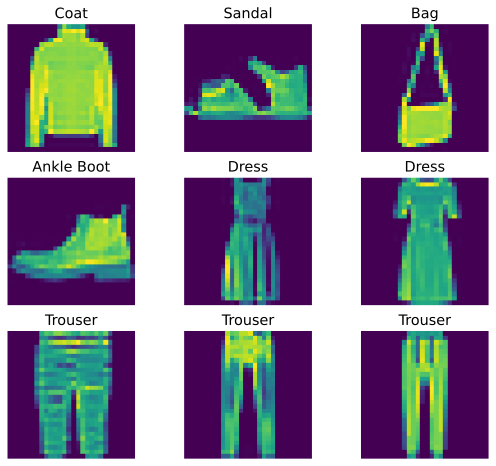

In [3]:
# Look at data

# Labels
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# plot data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data.train), size=(1,)).item()
    img, label = data.train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.imshow(img.squeeze())
    plt.axis("off")

In [4]:
X, y = next(iter(data.train_dl))
print(X.shape, X.dtype, y.shape, y.dtype)

torch.Size([1024, 1, 28, 28]) torch.float32 torch.Size([1024]) torch.int64


In [5]:
tic = time.time()
for X, y in data.train_dl:
    continue
f'{time.time() - tic:.2f} sec'

'11.01 sec'

In [6]:
X = torch.tensor([[1.0, 2.0, 3.0], [5.0, 6.0, 7.0]])
print ('X = ', X)
print ('Sum along 0 axis: ', X.sum(0, keepdim=True))
print ('Sum along 1 axis: ', X.sum(1, keepdim=True))

X =  tensor([[1., 2., 3.],
        [5., 6., 7.]])
Sum along 0 axis:  tensor([[ 6.,  8., 10.]])
Sum along 1 axis:  tensor([[ 6.],
        [18.]])


In [7]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp/partition

Y = softmax(X)
print (Y)
print (Y.sum(1, keepdim=True))

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])
tensor([[1.],
        [1.]])


In [8]:
X = torch.randn((2,5))
print (X)
Y = softmax(X)
print (Y)
print (Y.sum(1, keepdim=True))

tensor([[-0.7032,  0.3175,  1.0316,  0.0782,  0.9120],
        [ 0.0682,  0.2835, -0.1408,  0.8743,  0.7210]])
tensor([[0.0600, 0.1666, 0.3403, 0.1312, 0.3019],
        [0.1387, 0.1720, 0.1125, 0.3105, 0.2664]])
tensor([[1.],
        [1.]])


In [9]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[torch.arange(len(y_hat)), y]).mean()


def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp/partition


# Create model
class Classifier(nn.Module):
    def __init__(self, fan_in, fan_out):
        super().__init__()
        # self.model = nn.Sequential(nn.Linear(28*28,1))
        self.W = torch.randn((fan_in, fan_out))/fan_in**0.5
        self.W.requires_grad = True
        self.b = torch.zeros(fan_out, requires_grad=True)

    def parameters(self):
        return [self.W, self.b]

    def forward(self, x):
        x = x.view(-1, self.W.shape[0])
        out = x @ self.W + self.b
        return softmax(out)

    def loss(self, y_hat, y):
        return cross_entropy(y_hat, y)

    def accuracy(self, Y_hat, y):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        preds = Y_hat.argmax(axis=1).long()
        compare = (preds == y).float()
        return compare.mean()


Epoch (0): train loss = 0.74, val loss = 0.78, acc = 0.76
Epoch (5): train loss = 0.51, val loss = 0.56, acc = 0.81
Epoch (10): train loss = 0.50, val loss = 0.52, acc = 0.82
Epoch (15): train loss = 0.45, val loss = 0.56, acc = 0.79
Epoch (20): train loss = 0.45, val loss = 0.52, acc = 0.83
Epoch (25): train loss = 0.49, val loss = 0.53, acc = 0.82
Epoch (30): train loss = 0.44, val loss = 0.51, acc = 0.83
Epoch (35): train loss = 0.49, val loss = 0.51, acc = 0.82
Epoch (40): train loss = 0.44, val loss = 0.50, acc = 0.83
Epoch (45): train loss = 0.40, val loss = 0.49, acc = 0.84
Epoch (50): train loss = 0.44, val loss = 0.45, acc = 0.86
Epoch (55): train loss = 0.52, val loss = 0.49, acc = 0.83
Epoch (60): train loss = 0.49, val loss = 0.54, acc = 0.82
Epoch (65): train loss = 0.52, val loss = 0.48, acc = 0.83
Epoch (70): train loss = 0.50, val loss = 0.49, acc = 0.83
Epoch (75): train loss = 0.45, val loss = 0.51, acc = 0.81
Epoch (80): train loss = 0.46, val loss = 0.48, acc = 0.84

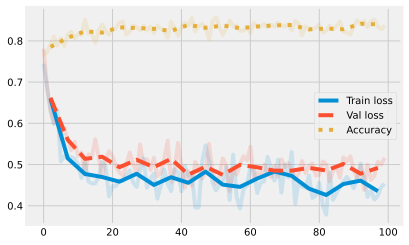

In [11]:
max_epochs = 100
smooth = 5  # must divide max_epochs
model = Classifier(fan_in=784, fan_out=10)
params = model.parameters()

epochs = []
train_losses = []
val_losses = []
accs = []
for epoch in range(max_epochs):
    losses = []
    for step, batch in enumerate(data.train_dl):

        # Get minibatch
        x, y = batch

        # Forward pass
        logits = model.forward(x)

        # Get loss
        train_loss = model.loss(logits, y)

        # Backward pass
        for p in params:
            p.grad = None
        train_loss.backward()

        # Update params
        if epoch < 25:
            lr = 0.1
        elif epoch < 50:
            lr = 0.01
        else:
            lr = 0.001
        for p in params:
            p.data += - lr*p.grad

    # Print losses
    # Do not let computations effect gradient
    with torch.no_grad():
        epochs.append(epoch)
        # Training losses
        train_losses.append(train_loss.item())
        # Val losses
        for batch in data.val_dl:
            x, y = batch
            logits = model.forward(x)
            val_loss = model.loss(logits, y)
            acc = model.accuracy(logits, y)
            break
        val_losses.append(val_loss.item())
        accs.append(acc.item())
        # Print
        if epoch % smooth == 0:
            print(f'Epoch ({epoch}): train loss = {train_loss.item():.2f}, val loss = {val_loss.item():.2f}, acc = {acc.item():.2f}')

# Smooth for plotting

tl = torch.tensor(train_losses).view(-1, smooth).mean(axis=1)
vl = torch.tensor(val_losses).view(-1, smooth).mean(axis=1)
ac = torch.tensor(accs).view(-1, smooth).mean(axis=1)
ep = torch.tensor(epochs).float().view(-1, smooth).mean(axis=1)

# Make plots
plt.plot(epochs, train_losses, 'C0', alpha=0.15)
plt.plot(epochs, val_losses, 'C1', alpha=0.15)
plt.plot(epochs, accs, 'C2', alpha=0.15)
plt.plot(ep, tl, 'C0', label='Train loss')
plt.plot(ep, vl, 'C1--', label='Val loss')
plt.plot(ep, ac, 'C2:', label='Accuracy')

plt.legend();


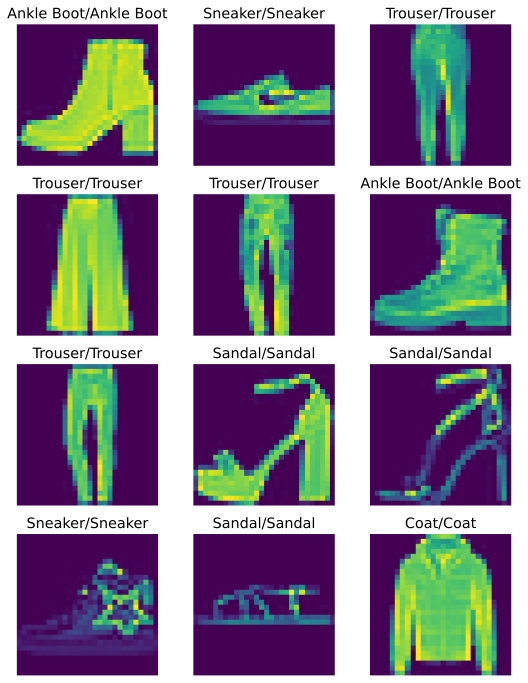

In [12]:
# Let's test prediction
#x, y = data.train[0][0], data.val[0][1]
#with torch.no_grad():
#    pred = model.forward(x)
#    predicted, actual = labels_map[pred[0].argmax(0).item()], labels_map[y]
#    print(f'Predicted: "{predicted}", Actual: "{actual}"')

figure = plt.figure(figsize=(8, 12))
cols, rows = 3, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data.train), size=(1,)).item()
    img, label = data.train[sample_idx]
    pred = model.forward(img)
    predicted = labels_map[pred[0].argmax(0).item()]
    figure.add_subplot(rows, cols, i)
    plt.title(predicted + '/' + labels_map[label])
    plt.imshow(img.squeeze())
    plt.axis("off")

Show those we got wrong:


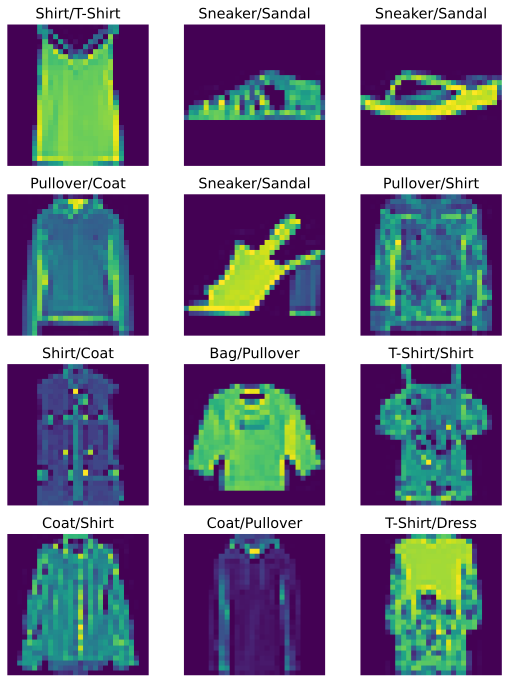

In [13]:
figure = plt.figure(figsize=(8, 12))
cols, rows = 3, 4
wrong = False
print ('Show those we got wrong:')
for i in range(1, cols * rows + 1):
    while wrong == False:
        sample_idx = torch.randint(len(data.train), size=(1,)).item()
        img, label = data.train[sample_idx]
        pred = model.forward(img)
        predicted = labels_map[pred[0].argmax(0).item()]
        if pred[0].argmax(0).item() != label:
            wrong = True
    wrong = False
    figure.add_subplot(rows, cols, i)
    plt.title(predicted + '/' + labels_map[label])
    plt.imshow(img.squeeze())
    plt.axis("off")

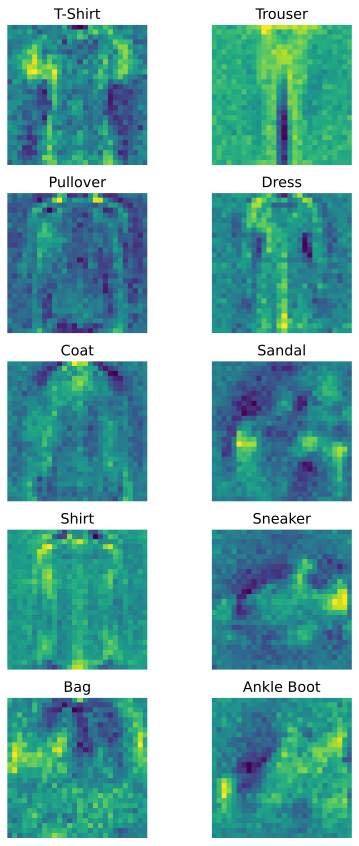

In [14]:
# Let's look at weights
myW = params[0].T.view(10,28,28)

figure = plt.figure(figsize=(6, 15))
cols, rows = 2, 5
for i in range(1, cols * rows + 1):
    #sample_idx = torch.randint(len(data.train), size=(1,)).item()
    img = myW[i-1].detach().numpy()
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[i-1])
    plt.imshow(img.squeeze())
    plt.axis("off")



In [ ]:
# Old Stuff

In [58]:
xx = torch.tensor(train_losses)
yy = torch.tensor(train_losses)

print (xx.view(-1,5).mean(axis=1))
print (xx[:10])

tensor([0.6406, 0.5222, 0.4915, 0.4848, 0.4681, 0.4480, 0.4468, 0.4631, 0.4741,
        0.4507, 0.4299, 0.4564, 0.4625, 0.4321, 0.4556, 0.4444, 0.4424, 0.4497,
        0.4328, 0.4584])
tensor([0.7713, 0.7137, 0.6581, 0.5372, 0.5227, 0.6012, 0.4754, 0.5462, 0.4909,
        0.4973])


In [7]:
# Random data for testing
torch.manual_seed(1701)

# Create synthetic data
num_train=1000
num_val=1000
w = torch.tensor([2, -3.4])
b = 4.2
n = num_train + num_val
noise = 0.1

X = torch.randn((n, len(w)))
y = X @ w.reshape(-1, 1) + b + noise


class Mydata(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


# Create dataset
dataset = Mydata(X, y)

# Create dataloader
data = DataLoader(dataset, batch_size=32)

for x, y in data:
    print (x.shape, y.shape)
    break


# Create model
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(2,1))

    def forward(self, x):
        x = self.model(x)
        return x

model = MyModel()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.03, weight_decay=0.1)


def train(data, model, loss_fn, optimizer):
    size = len(data.dataset)
    model.train()
    for batch, (X, y) in enumerate(data):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



#train(data, model, loss_fn, optimizer)

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(data, model, loss_fn, optimizer)
print("Done!")

#for p in model.parameters():
#    print (p)

print (f'\nThe final parameters are (with w = {w} and b = {b} as correct answer): ')
print (model.state_dict())
answ = w - model.state_dict()['model.0.weight']
ansb = b - model.state_dict()['model.0.bias']
print(f'error in estimating w: {answ}')
print(f'error in estimating b: {ansb}')





torch.Size([32, 2]) torch.Size([32, 1])
Epoch 1
-------------------------------
loss: 50.698044  [    0/ 2000]
Epoch 2
-------------------------------
loss: 0.206054  [    0/ 2000]
Epoch 3
-------------------------------
loss: 0.097946  [    0/ 2000]
Done!

The final parameters are (with w = tensor([ 2.0000, -3.4000]) and b = 4.2 as correct answer): 
OrderedDict([('model.0.weight', tensor([[ 1.9062, -3.2327]])), ('model.0.bias', tensor([4.0953]))])
error in estimating w: tensor([[ 0.0938, -0.1673]])
error in estimating b: tensor([0.1047])


In [34]:
model.state_dict()

OrderedDict([('model.0.weight', tensor([[ 2.0000, -3.3999]])),
             ('model.0.bias', tensor([4.2999]))])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


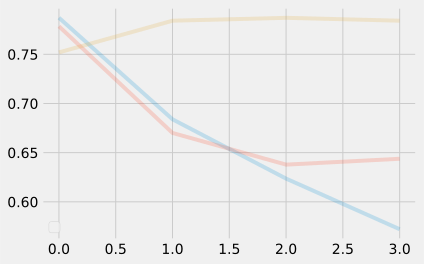

In [77]:
smooth = 1
tl = torch.tensor(train_losses).view(-1,smooth).mean(axis=1)
vl = torch.tensor(val_losses).view(-1,smooth).mean(axis=1)
ac = torch.tensor(accs).view(-1,smooth).mean(axis=1)
ep = torch.tensor(epochs).float().view(-1,smooth).mean(axis=1)

plt.plot(epochs, train_losses, 'C0',alpha=0.2)
plt.plot(epochs, val_losses, 'C1',alpha=0.2)
plt.plot(epochs, accs, 'C2',alpha=0.2)
#plt.plot(ep, tl, 'C0',label='Train loss')
#plt.plot(ep, vl, 'C1--',label='Val loss')
#plt.plot(ep, ac, 'C2:',label='Accuracy')

#print (xx.view(-1,5).mean(axis=1))
#plt.plot(epochs, train_losses, 'C0',label='Train loss')
#plt.plot(epochs, val_losses, 'C1--',label='Val loss')
#plt.plot(epochs, accs, 'C2--',label='Accuracy')

plt.legend();

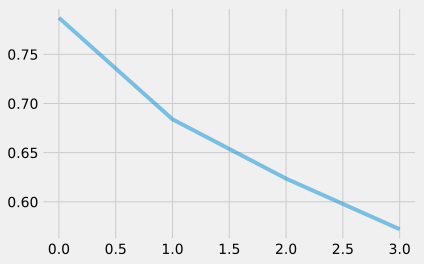

In [68]:
plt.plot(epochs, train_losses, 'C0',label='Train loss',alpha=0.5)